# Imports

In [ ]:
!pip install pytorch_lightning --quiet
!pip install pytorch-lightning-bolts --quiet

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks.base import Callback
from pl_bolts.datamodules.sklearn_datamodule import SklearnDataset

from sklearn.datasets import make_moons, make_circles
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Classes and Functions

In [ ]:
class FCnet(pl.LightningModule):

    def __init__(self, 
                 input_size=2, 
                 output_size=1, 
                 hidden_layers=[4,4], 
                 learning_rate=0.001, 
                 batch_norm=False, 
                 dropout_p=None,
                 activity_regularizers=None):
      
        super().__init__()

        self.learning_rate = learning_rate

        self.has_regularizer = False
        self.forward_states = pd.DataFrame(columns=['inp_1','inp_2'] + ['l'+str(i) for i in range(len(hidden_layers))] + ['output'])
        self.state = 'grid'
        self.batch_fs = pd.DataFrame()
        self.save_forward = False

        layer_sizes = [input_size] + hidden_layers + [output_size]

        self.layers = nn.ModuleDict()
        for i in range(len(hidden_layers)+1):
          self.layers['linear_' + str(i)] = nn.Linear(layer_sizes[i], layer_sizes[i+1])

          if i < len(hidden_layers):
            if batch_norm:
              self.layers['batch_norm_' + str(i)] = nn.BatchNorm1d(layer_sizes[i+1])

            self.layers['relu' + str(i)] = nn.ReLU()

            if dropout_p is not None:
              self.layers['dropout_' + str(i)] = nn.Dropout(p=dropout_p)

        self.layers['sigmoid'] = nn.Sigmoid()

        if activity_regularizers is not None:
          self.has_regularizer = True
          self.output_hook = OutputHook()
          for name, module in self.layers.items():
            if name.startswith('relu'):
              module.register_forward_hook(self.output_hook)
          
          self.activity_regularizers = []
          for regularizer, coeff in activity_regularizers:
            if regularizer == "l1":
              self.activity_regularizers.append((1, coeff))
            elif regularizer == "l2":
              self.activity_regularizers.append((2, coeff))
            else:
              raise NotImplementedError
            

    def forward(self, x):
        inp = x.view(x.size(0), -1)

        self._add_to_batch_fs('inp_1', inp.numpy()[:,0])
        self._add_to_batch_fs('inp_2', inp.numpy()[:,1])

        x = inp
        layer_count = 0
        for name, module in self.layers.items():
            x = module(x)
            
            if name.startswith('relu'):
              bin_o = (x > 0).int().cpu().numpy()
              str_bin_o = np.apply_along_axis(
                  lambda z: ''.join(str(a) for a in z), 1, bin_o)
              self._add_to_batch_fs('l'+str(layer_count), str_bin_o)
              layer_count += 1

        self._add_to_batch_fs('output', x.detach().numpy() > .5)
        self._save_batch_fs()

        return x 

    def _add_to_batch_fs(self, name, values):
        if self.save_forward:
            self.batch_fs[name] = values
    
    def _save_batch_fs(self):
        if self.save_forward:
            self.batch_fs['epoch'] = self.current_epoch
            self.batch_fs['ds'] = self.state
            self.forward_states = self.forward_states.append(self.batch_fs, ignore_index=True)
            self.batch_fs = pd.DataFrame()

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        penalty = 0.
        if self.has_regularizer:
          for output in self.output_hook:
            for norm, coeff in self.activity_regularizers:
              penalty += torch.norm(output, norm)
              penalty *= coeff
          self.output_hook.clear()

        loss = nn.BCELoss()
        loss_out = loss(y_hat.double(), y.unsqueeze(1).double())
        loss_out = loss_out + penalty

        self.log('train_loss', loss_out)
        return loss_out

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

class OutputHook(list):
  """ Hook to capture module outputs."""

  def __call__(self, module, input, output):
    self.append(output)

In [ ]:
class ApdfLogger(Callback):

  def __init__(self, frequency, grid, train):
    super().__init__()

    self.frequency = frequency
    self.cb_grid = grid
    self.cb_train = train
  
  def on_train_epoch_end(self, trainer, pl_module, outputs):
    if trainer.current_epoch % self.frequency == 0 and trainer.current_epoch > 0:
      pl_module.save_forward = True
      pl_module.freeze()

      pl_module.state = 'grid'
      pl_module(self.cb_grid)

      pl_module.state = 'train'
      pl_module(self.cb_train)

      pl_module.unfreeze()
      pl_module.save_forward = False

In [ ]:
from itertools import count
class IdGen():
  def __init__(self):
    self.seen = dict()
    self.counter = count()
  
  def setdefault(self, value):
    if value in self.seen:
      return self.seen[value]
    else:
      return self.seen.setdefault(value, next(self.counter))

In [ ]:
def plot_dataset(X, y):
  df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
  colors = {0:'red', 1:'blue'}
  fig, ax = plt.subplots(figsize=(5,5))
  grouped = df.groupby('label')
  for key, group in grouped:
      group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

In [ ]:
def get_apdf(model):

  all_apdf = model.forward_states.copy()
  all_apdf['output'] = all_apdf['output'].astype('int')

  all_apdf['actpatt'] = ''
  for layer_name in [col for col in all_apdf.columns if col.startswith('l')]:
    id_gen = IdGen()
    all_apdf[layer_name + '_bin'] = all_apdf[layer_name].apply(lambda x: id_gen.setdefault(x))
    all_apdf['actpatt'] = all_apdf['actpatt'] + all_apdf[layer_name]

  id_gen = IdGen()
  all_apdf['actpatt_bin'] = all_apdf['actpatt'].apply(lambda x: id_gen.setdefault(x))

  return all_apdf

In [ ]:
def plot_evolution(all_apdf, grid_size):
  apdf_num = all_apdf['epoch'].nunique()

  layers_cols = [col for col in all_apdf.columns if col.startswith('l') and col.endswith('bin')]
  n_layers = len(layers_cols)
  columns = layers_cols + ['actpatt_bin', 'output']
  col_names = ['Layer ' + str(i) for i in range(n_layers)] + ['All layers', 'Decision boundary']

  fig, axs = plt.subplots(apdf_num, len(columns), figsize=((n_layers+2)*5, (n_layers+2)*5))

  epochs = all_apdf['epoch'].unique()

  for col in range(len(columns)):
    for row in range(len(epochs)):

      ax = axs[row, col]

      view = all_apdf[(all_apdf['epoch'] == epochs[row]) & (all_apdf['ds'] == 'grid')]
      
      X = view['inp_1'].values.reshape(grid_size, grid_size)
      Y = view['inp_2'].values.reshape(grid_size, grid_size)
      Z = view[columns[col]].values.reshape(grid_size, grid_size)

      levels = view[columns[col]].unique()
      levels = np.sort(levels)
      levels = [-1] + list(levels) + [np.max(levels)+1]

      ax.contourf(X, Y, Z, alpha=.7, levels=levels, cmap="twilight")

      view=all_apdf[(all_apdf['epoch'] == epochs[row]) & (all_apdf['ds'] == 'train')]
      ax.scatter(view['inp_1'], view['inp_2'], s=1, color='white', alpha=.4)

      ax.set(adjustable='box', aspect='equal')
      ax.set_ylabel("Epoch " + str(int(epochs[row])) if col==0 else None, size=12)
      ax.set_title(str(col_names[col]) if row==0 else None, size=12)

  for ax in axs.flat:
      ax.label_outer()

  fig.tight_layout()
  fig.show()

In [ ]:
class Experiment():
  
  def __init__(self,
               X, y,
               hidden_layers = [8,8],
               n_epochs=100,
               apdf_saving_ratio=5, 
               learning_rate = 0.05,
               batch_norm=False,
               dropout_p=None, 
               grid_size=1000,
               activity_regularizers=None):
  
    self.input_size = 2
    self.output_size = 1
    self.hidden_layers = hidden_layers
    self.learning_rate = learning_rate
    self.batch_norm = batch_norm
    self.dropout_p = dropout_p
    
    self.n_epochs = n_epochs

    self.apdf_saving_ratio = apdf_saving_ratio
    
    self.X = X
    self.y = y

    # Create grid of points for contourf
    self.grid_size = grid_size
    bins = np.linspace(0, 1, self.grid_size)
    gridX = np.array(np.meshgrid(bins, bins)).T.reshape(-1,2)
    self.gridX = torch.from_numpy(gridX).float()

    # Create train_loader
    train_ds = SklearnDataset(X, y)
    self.train_loader = DataLoader(train_ds, batch_size=16)  

    self.model = FCnet(input_size=self.input_size, 
                       output_size=self.output_size, 
                       hidden_layers=self.hidden_layers, 
                       learning_rate=self.learning_rate, 
                       batch_norm=self.batch_norm, 
                       dropout_p=self.dropout_p,
                       activity_regularizers=activity_regularizers)

  def plot_dataset(self):
    plot_dataset(self.X, self.y)

  def train(self):
    trainer = pl.Trainer(max_epochs=self.n_epochs+1, 
                         progress_bar_refresh_rate=30,
                         callbacks=[ApdfLogger(self.n_epochs//self.apdf_saving_ratio, self.gridX, torch.from_numpy(self.X).float())])
    trainer.fit(self.model, self.train_loader)

    # Get apdfs
    self.all_apdf = get_apdf(self.model)

  def plot(self):
    # Plot apdfs
    plot_evolution(self.all_apdf, self.grid_size)
    

In [ ]:
def get_trainset(name, n_samples=1000, **kwargs):
  if name == "moons":
    X, y = make_moons(n_samples=n_samples, **kwargs)
  elif name == "circles":
    X, y = make_circles(n_samples=n_samples, **kwargs)
  elif name == "xor":
    rng = np.random.RandomState(0)
    X = np.array([np.random.uniform(-1, 1, n_samples), np.random.uniform(-1, 1, n_samples)]).T
    y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
  else:
    raise NotImplementedError
  
  # Scale data
  scaler = MinMaxScaler()
  X = scaler.fit_transform(X)

  return X, y

# Datasets

### Moons

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html

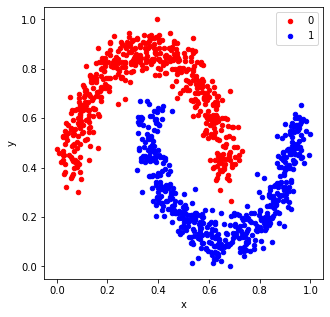

In [ ]:
X, y = get_trainset("moons", n_samples=1000, noise=0.1)
plot_dataset(X, y)

### Circles

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html

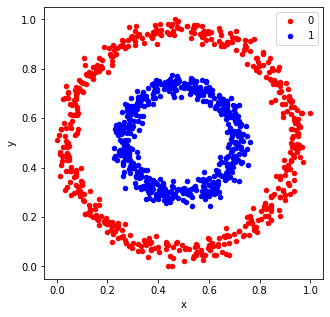

In [ ]:
X, y = get_trainset("circles", n_samples=1000, noise=0.05, factor=.5)
plot_dataset(X, y)

### XOR

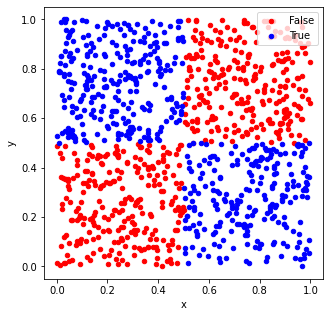

In [ ]:
X, y = get_trainset("xor", n_samples=1000)
plot_dataset(X, y)

# Experiments

#### Usage
```
exp = Experiment(X, y,
                 hidden_layers = [8,8],
                 n_epochs = 100,
                 learning_rate = 0.05,
                 batch_norm=False,
                 dropout_p=None, 
                 grid_size=1000,
                 activity_regularizers=None)
exp.train()
exp.plot()
```
#### Details
- ```hidden_layers: list```: takes a list of neurons/layers.
- ```n_epochs: int```: takes the number of epochs.
- ```learning_rate: float```: takes the learning_rate (constant).
- ```batch_norm: boolean```: use batch norm? (https://arxiv.org/abs/1502.03167).
- ```dropout_p: float```: use dropout? Takes probability of disabling a neuron (https://en.wikipedia.org/wiki/Dilution_(neural_networks)#Dropout).
- ```grid_size: int```: resolution of points for plots.
- ```activity_regularizers: list```: list of couples (regularizer, lambda). The available regularizers are "l1" and "l2".



## Plots

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name   | Type       | Params
--------------------------------------
0 | layers | ModuleDict | 105   
--------------------------------------
105       Trainable params
0         Non-trainable params
105       Total params


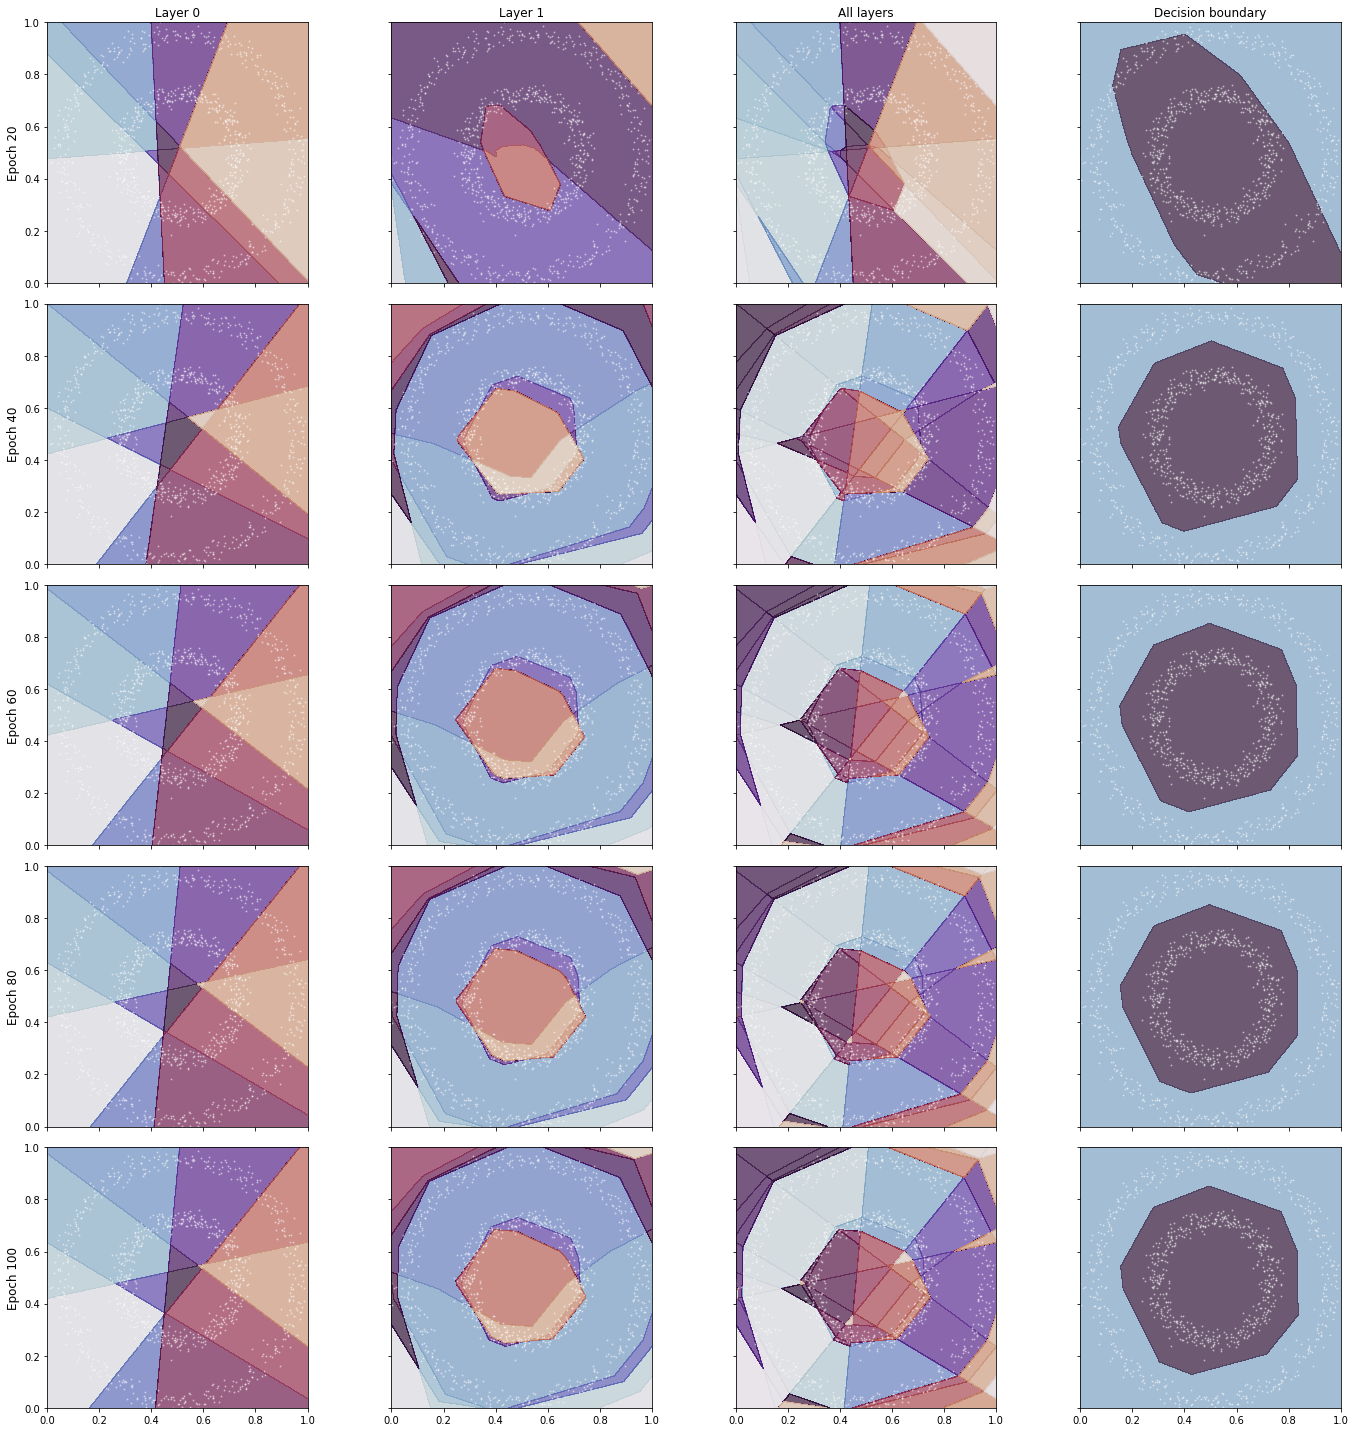

In [ ]:
X, y = get_trainset("circles", n_samples=1000, noise=0.05, factor=.5)

exp1 = Experiment(X, y,
                 hidden_layers = [8,8],
                 n_epochs = 100,
                 learning_rate = 0.05,
                 batch_norm=False,
                 dropout_p=None, 
                 grid_size=1000)
exp1.train()
exp1.plot()

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name   | Type       | Params
--------------------------------------
0 | layers | ModuleDict | 137   
--------------------------------------
137       Trainable params
0         Non-trainable params
137       Total params


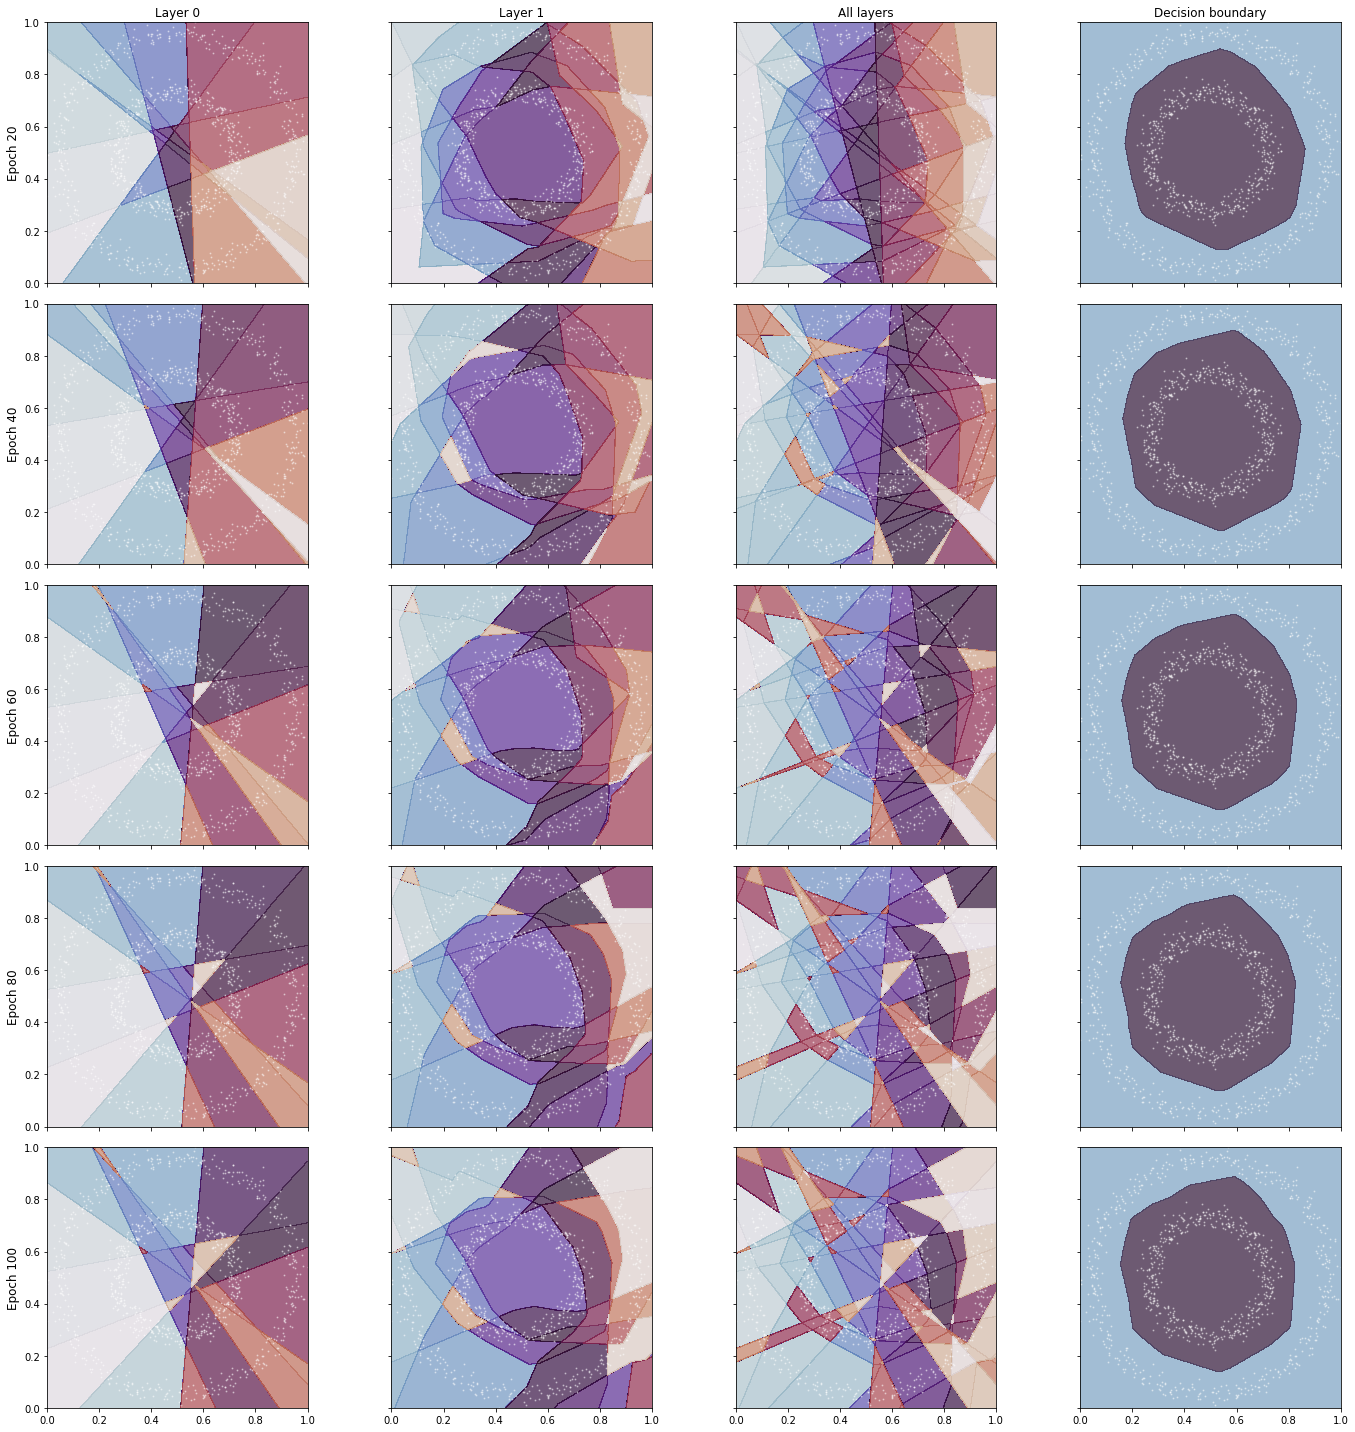

In [ ]:
X, y = get_trainset("circles", n_samples=1000, noise=0.05, factor=.5)

exp2 = Experiment(X, y,
                 hidden_layers = [8,8],
                 n_epochs = 100,
                 learning_rate = 0.05,
                 batch_norm=True,
                 dropout_p=None, 
                 grid_size=1000)
exp2.train()
exp2.plot()

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name   | Type       | Params
--------------------------------------
0 | layers | ModuleDict | 105   
--------------------------------------
105       Trainable params
0         Non-trainable params
105       Total params


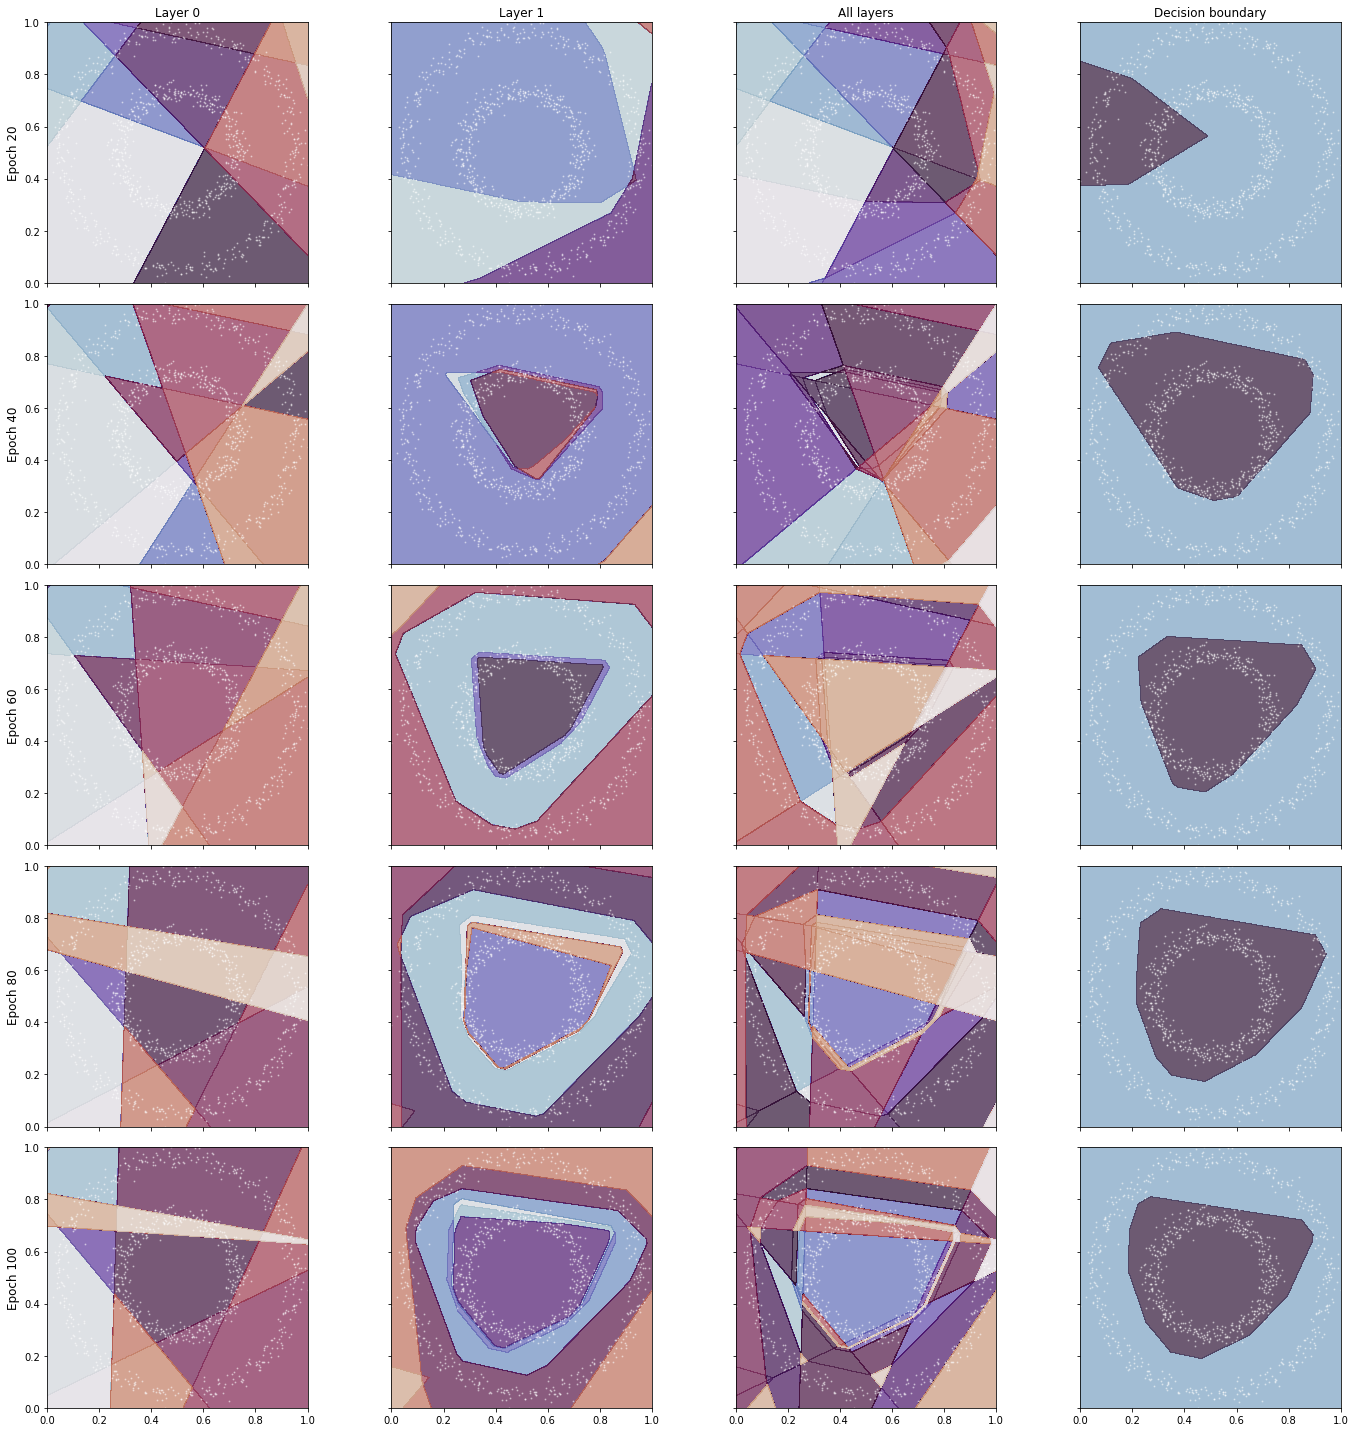

In [ ]:
X, y = get_trainset("circles", n_samples=1000, noise=0.05, factor=.5)

exp3 = Experiment(X, y,
                 hidden_layers = [8,8],
                 n_epochs = 100,
                 learning_rate = 0.05,
                 batch_norm=False,
                 dropout_p=.5, 
                 grid_size=1000)
exp3.train()
exp3.plot()

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name   | Type       | Params
--------------------------------------
0 | layers | ModuleDict | 105   
--------------------------------------
105       Trainable params
0         Non-trainable params
105       Total params


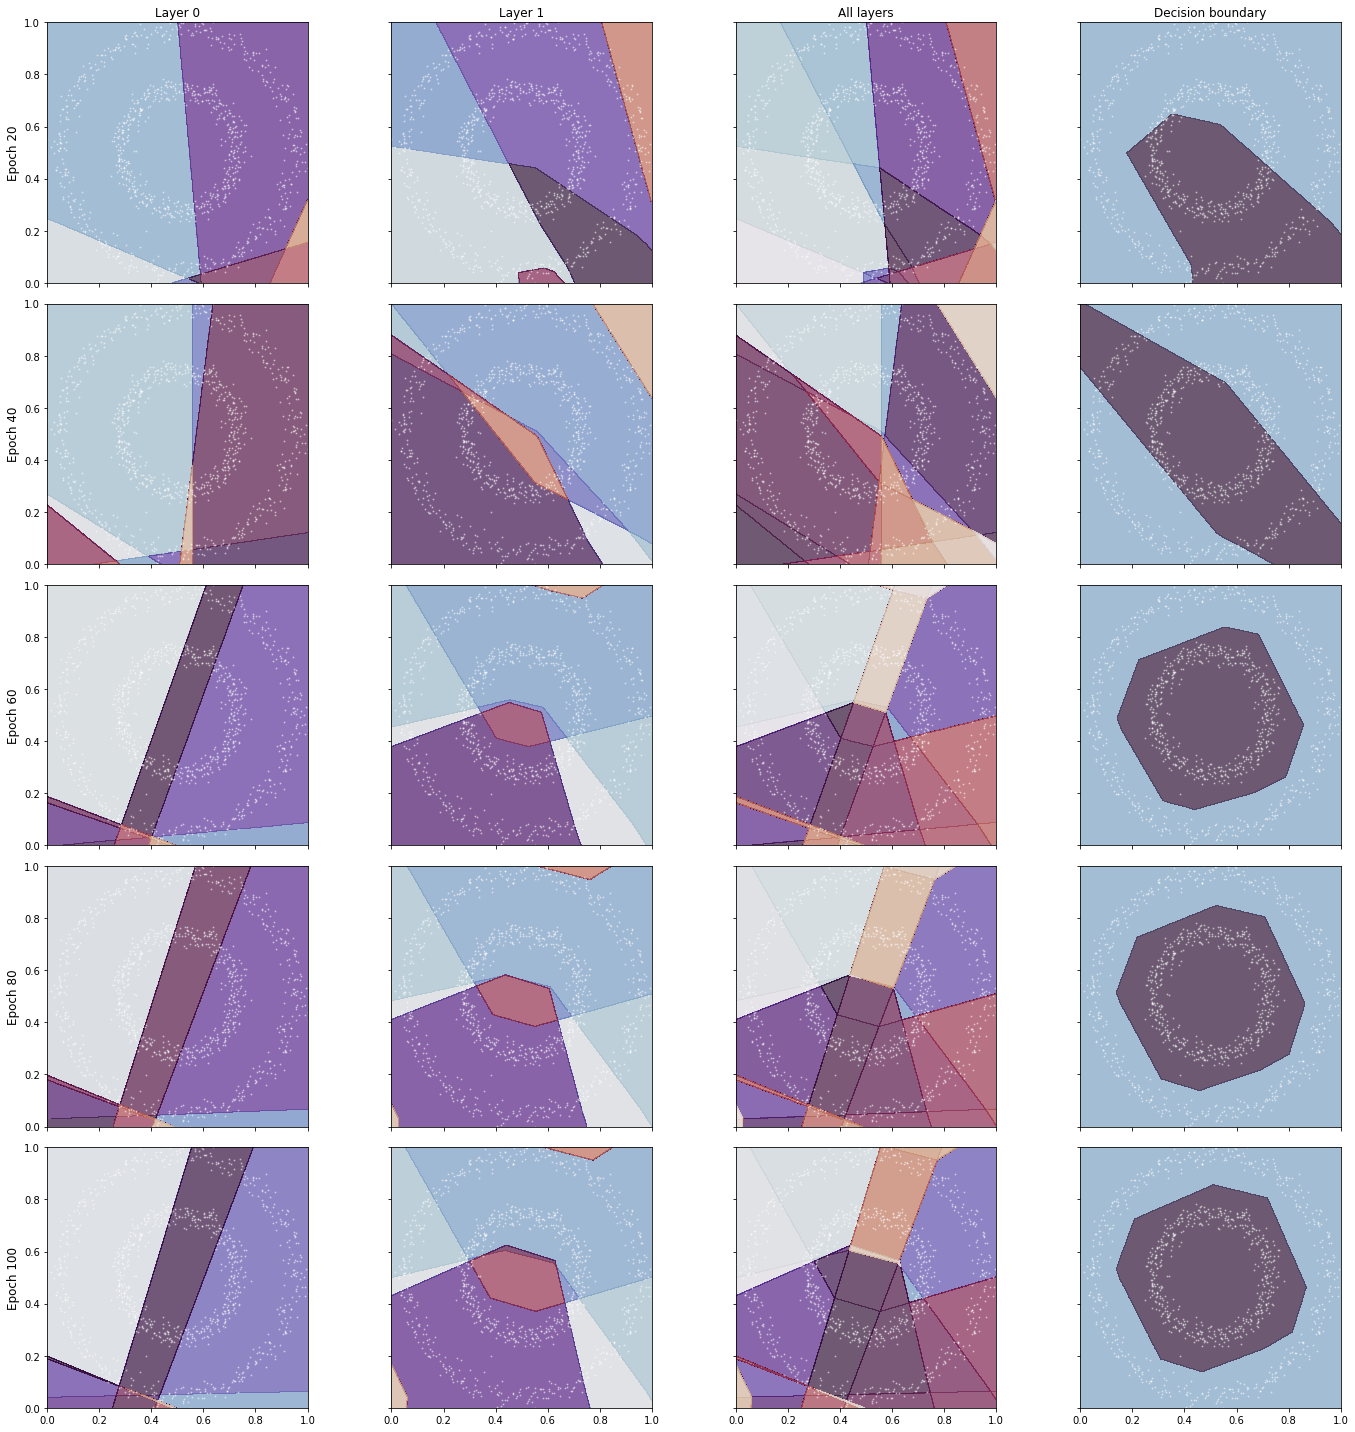

In [25]:
X, y = get_trainset("circles", n_samples=1000, noise=0.05, factor=.5)

exp4 = Experiment(X, y,
                 hidden_layers = [8,8],
                 n_epochs = 100,
                 learning_rate = 0.05,
                 batch_norm=False,
                 dropout_p=None, 
                 grid_size=1000,
                 activity_regularizers=[("l1",0.0001)])
exp4.train()
exp4.plot()